# Advanced NLP Assignment 1: Feature-Based SRL Pipeline

## Link to the model

https://drive.google.com/file/d/1obVbtWRfjqKZ7M5_nnpkBTkoP-nJbneh/view?usp=sharing

### 1. Preproccesing

The train dataset(en_ewt-up-train.conllu) and test dataset(en_ewt-up-test.conllu) are stored in the `data/` directory. 
Below, we have created a function `preprocess_propbank()` which converts the `.conllu` file to a list of dictionaries with a list of tokens called `words`,  a 1-based index of the predicate called `predicate_id`, a list depicting the argument structure of the corresponding predicated called `arguments` and the sentence id of each sentence from the `.conllu` dataset, called `sentence_id`.

I also replicated each sentence from the original dataset for each predicate present in the sentence. For every predicate, I loop through the argument columns (column 11 onwards) and check the value to find a "V" as the value of the argument structure is always "V" if the token itself is the corresponding predicate. That is how I matched the predicate to its corresponding argument column. 

In [1]:
def preprocess_propbank(file_path):
    """
    Preprocesses the Universal Proposition Bank data from a CoNLL file.
    Extracts only words, predicate IDs, and argument structures.
    Correctly associates each argument structure with its corresponding predicate.

    Args:
        file_path (str): Path to the .conllu file.

    Returns:
        list: A list of dictionaries, where each dictionary represents a preprocessed sentence.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()

    sentences = data.strip().split("\n\n")  # Each sentence is separated by a blank line
    preprocessed_data = []

    for sentence_block in sentences:
        lines = sentence_block.strip().split("\n")
        words = []
        predicates = {}  # Store predicate index and sense
        sentence_id = "_"
        invalid_word_id = False

        # Extract sentence ID
        for line in lines:
            if line.startswith("# sent_id"):
                sentence_id = line.split(" = ")[1]
                break

        # Filter out comment lines
        lines = [x for x in lines if not x.startswith("#")]

        # Extract words and predicates
        for line_idx, line in enumerate(lines):
            parts = line.split("\t")

            # Ensure the line has at least 10 columns
            if len(parts) < 10:
                continue  

            token_id_str = parts[0]

            # Ignore non-integer token IDs (e.g., "8.1", "_")
            if not token_id_str.isdigit():
                invalid_word_id = True
                continue  

            token_id = int(token_id_str)
            token_form = parts[1]
            predicate_sense = parts[10] if len(parts) > 10 else "_"

            words.append(token_form)  # Collect words of the sentence

            # If it's a predicate, store its index
            if predicate_sense != "_":
                predicates[token_id] = predicate_sense  

        if invalid_word_id:
            continue

        # Extract argument structures for each predicate
        for pred_index, pred_sense in predicates.items():
            arguments = ["O"] * len(words)  # Default all tokens to "O"

            # Find the argument column corresponding to this predicate
            for tok_idx, line in enumerate(lines):
                parts = line.split("\t")

                if len(parts) > 10:  # Ensure argument columns exist
                    # Iterate over all argument columns to find the one with "V" for this predicate
                    for col_idx in range(11, len(parts)):
                        if parts[col_idx] == "V" and tok_idx == pred_index - 1:
                            # This column corresponds to the current predicate
                            for line_idx2, line2 in enumerate(lines):
                                parts2 = line2.split("\t")
                                if len(parts2) > col_idx:
                                    arg_label = parts2[col_idx]
                                    if arg_label != "_":
                                        arguments[line_idx2] = arg_label
                            break  # Stop searching once the correct column is found

            # Ensure the number of arguments matches the number of words
            if len(arguments) != len(words):
                print(f"Mismatch in sentence: {words}")
                continue  # Skip this sentence or handle the mismatch

            preprocessed_data.append({
                "words": words,
                "predicate_id": pred_index,
                "arguments": arguments,
                "sentence_id": sentence_id
            })

    return preprocessed_data

train_file = "data/en_ewt-up-train.conllu"
test_file = "data/en_ewt-up-test.conllu"

preprocessed_train_data = preprocess_propbank(train_file)
preprocessed_test_data = preprocess_propbank(test_file)



One issue I faced during preprocessing was that in rare cases, the `word_id` in `.conllu` datasets contained a decimal(e.g. 24.1, 8.1). These were more frequent in the train set as compared to the test set. In the entire test set, there was just one such instance, and in the train set, there were 24 instances. I tried to handle them, by changing the symbol, and be reindexing the sentence, but I was getting a bunch of index errors. So I decided to drop all of them. Hence, you may notice that my token and sentence statistics will be lower than it should be.

The below two cells are just to capture the preprocessed dataset into files.

In [2]:
with open('preprocessed_train_data.csv', 'w', encoding='utf-8') as f:
    for line in preprocessed_train_data:
        f.write(f"{line}\n")

In [3]:
with open('preprocessed_test_data.csv', 'w', encoding='utf-8') as f:
    for line in preprocessed_test_data:
        f.write(f"{line}\n")

The below cell is to check if there was a mismatch in the number of words, and the number of arguments, something which I was experiencing when dealing with the above described decimals in the IDs

In [4]:
for sentence in preprocessed_train_data:
    assert len(sentence["words"]) == len(sentence["arguments"]), "Mismatch in train data"

for sentence in preprocessed_test_data:
    assert len(sentence["words"]) == len(sentence["arguments"]), "Mismatch in test data"

### 2. Gathering Statistics

I created a basic function to calculate the number of sentences and number of tokens for both our preprocessed data as well as a similar one for the original dataset.

In [5]:
def gather_statistics(preprocessed_data):
    """
    Gathers statistics about the preprocessed data.

    Args:
        preprocessed_data (list): List of preprocessed sentences.

    Returns:
        dict: A dictionary containing statistics.
    """
    num_sentences = len(preprocessed_data)
    num_tokens = sum(len(sentence["words"]) for sentence in preprocessed_data)

    return {
        "num_sentences": num_sentences,
        "num_tokens": num_tokens
    }

def gather_raw_statistics(file_path):
    """
    Gathers statistics about the raw CoNLL data before preprocessing.

    Args:
        file_path (str): Path to the CoNLL file.

    Returns:
        dict: A dictionary containing statistics.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()

    # Split the data into sentences (each sentence is separated by a blank line)
    sentences = data.strip().split("\n\n")
    num_sentences = len(sentences)

    # Count the number of tokens (non-comment lines in each sentence)
    num_tokens = 0
    for sentence in sentences:
        lines = sentence.strip().split("\n")
        # Filter out comment lines (lines starting with "#")
        num_tokens += len([line for line in lines if not line.startswith("#")])

    return {
        "num_sentences": num_sentences,
        "num_tokens": num_tokens
    }

train_raw_stats = gather_raw_statistics("data/en_ewt-up-train.conllu")
test_raw_stats = gather_raw_statistics("data/en_ewt-up-test.conllu")

train_stats = gather_statistics(preprocessed_train_data)
test_stats = gather_statistics(preprocessed_test_data)

print("Train Statistics (Before Preprocessing):", train_raw_stats)
print("Test Statistics (Before Preprocessing):", test_raw_stats)
print("Train Statistics (After Preprocessing):", train_stats)
print("Test Statistics (After Preprocessing):", test_stats)

Train Statistics (Before Preprocessing): {'num_sentences': 12543, 'num_tokens': 204609}
Test Statistics (Before Preprocessing): {'num_sentences': 2077, 'num_tokens': 25097}
Train Statistics (After Preprocessing): {'num_sentences': 40396, 'num_tokens': 1024323}
Test Statistics (After Preprocessing): {'num_sentences': 4863, 'num_tokens': 101518}


### 3. Feature Extraction

For our Semantic Role Labelling task, the three features I decided to use are:

1. Directed Dependency Path from Token to Predicate + Predicate Lemma
    This feature captures the syntactic relationship between a token and the predicate in the sentence. It consists of the directed dependency path from the token to the predicate, concatenated with the lemma of the predicate. For example, if the dependency path from a token to the predicate is `nsubj -> dobj` and the predicate lemma is `morph`, the feature will be `nsubj->dobj->morph`.
    The dependency path provides syntactic information about how the token relates to the predicate. Dependency labels (e.g., `nsubj`, `dobj`) explicitly mark syntactic roles (subject, object) relative to the predicate, which often correlate with semantic roles (e.g., `nsubj` tokens tend to be `ARG0`s). The predicate lemma helps generalize across different morphological variations of a verb (eg. `running` and `ran`, `eat` and `ate`). This feature is particularly useful for Logistic Regression because it encodes both syntactic and semantic information in a structured way, allowing the model to learn patterns in the data.

2. Part-of-Speech (POS) tag of the Token
    This feature represents the part-of-speech (POS) tag of the token, such as NOUN, VERB, ADJ, etc. The POS tag is extracted using SpaCy which is a toolkit used for linguistic parsing. POS tags provide important syntactic information about the role of a token in the sentence. For example, nouns are often arguments of predicates (e.g., `ARG0`, `ARG1`), while adverbs often modify predicates (e.g., `ARGM-ADV`). By including POS tags as a feature, the model can learn to associate specific syntactic roles with semantic roles. This is especially useful for Logistic Regression, as it helps the model generalize across different lexical items by focusing on their syntactic properties.

3. Relative Position of the Token to the Predicate
    This feature captures the relative position of the token with respect to the predicate in the sentence. It is calculated as the difference between the token's index and the predicate's index (e.g., `token_index - predicate_index`). A negative value indicates that the token appears before the predicate, while a positive value indicates that it appears after.
    The relative position of a token to the predicate is a strong indicator of its semantic role. For example, subjects (`ARG0`) often appear before the predicate, while objects (`ARG1`, `ARG2`) often appear after. This feature helps the model capture positional patterns in the data, which are important for distinguishing between different argument types. Logistic Regression benefits from this feature because it provides a simple yet effective way to encode positional information.
    The relative position of a token to the predicate is a strong indicator of its semantic role. For example, subjects (`ARG0`) often appear before the predicate, while objects (`ARG1`, `ARG2`) often appear after. This feature helps the model capture positional patterns in the data, which are important for distinguishing between different argument types. Logistic Regression benefits from this feature because it provides a simple yet effective way to encode positional information.

Note: As we have pre-tokenized sentences from the .conllu datasets, passing the entire sentence together to spacy caused a tokenization mismatch where Spacy's tokenization created 10000 more tokens in the train dataset that we didn't have labels for. To handle this, we used the `Doc` object of Spacy and passed our tokenized list of sentences to the spacy pipeline. This resolved the tokenization mismatch, as Spacy's tokenization was bypassed.

In [6]:
import spacy
from spacy.tokens import Doc

nlp = spacy.load("en_core_web_md")

def extract_features(sentence, predicate_id):
    """
    Extracts features for each token in the sentence based on the predicate_id.
    Note: predicate_id is 1-based (e.g., predicate_id=4 refers to the 4th word in the sentence).

    Args:
        sentence (list): List of words in the sentence.
        predicate_id (int): 1-based index of the predicate in the sentence.

    Returns:
        list: A list of dictionaries, where each dictionary contains features for a token.
    """
    # Convert predicate_id to 0-based index for Python
    predicate_index = predicate_id - 1

    # Join the sentence into a single string for SpaCy processing
    raw_doc = Doc(nlp.vocab, words=sentence)
    doc = nlp(raw_doc)
    
    # Initialize a list to store features for each token
    features = []

    # Get the predicate token and its lemma
    predicate_token = doc[predicate_index]
    predicate_lemma = predicate_token.lemma_  # Use the lemma of the predicate

    # Function to safely traverse the dependency tree and get the path to the predicate
    def get_dependency_path(token, predicate_token):
        """
        Traverses the dependency tree from the token to the predicate token, avoiding cycles.

        Args:
            token (spacy.Token): The starting token.
            predicate_token (spacy.Token): The predicate token.

        Returns:
            list: A list of dependency relations forming the path to the predicate.
        """
        path = []
        current_token = token
        visited = set()  # To avoid cycles

        # Traverse the dependency tree until we reach the predicate or hit a cycle
        while current_token.i != predicate_token.i:
            if current_token.i in visited:
                # If we encounter a cycle, stop traversal
                break
            if current_token.dep_ == "ROOT":
                break
            visited.add(current_token.i)
            path.append(current_token.dep_)
            current_token = current_token.head

        # Add the predicate's lemma to the path
        path.append(predicate_lemma)  # Use the predicate's lemma here
        return path

    # Iterate over each token in the sentence
    for token in doc:
        # Feature 1: Directed dependency path from the token to the predicate + predicate lemma
        dep_path = get_dependency_path(token, predicate_token)
        feature1 = "->".join(dep_path)

        # Feature 2: Part-of-speech tag of the token
        feature2 = token.pos_

        # Feature 3: Relative position of the token to the predicate
        feature3 = token.i - predicate_index

        # Append the features for this token to the list
        features.append({
            "dep_path_predicate": feature1,
            "pos_tag": feature2,
            "relative_position": feature3
        })
    # Debug: Print the number of tokens and features
    if len(sentence) != len(features):
        print(f"Tokenization Mismatch")

    return features


In [7]:
# Example usage:
sentence = ["What", "if", "Google", "Morphed", "Into", "GoogleOS", "?"]
predicate_id = 4  # The predicate is "Morphed" (4th word, index 3 in Python)
features = extract_features(sentence, predicate_id)
print(features)

[{'dep_path_predicate': 'morph', 'pos_tag': 'PRON', 'relative_position': -3}, {'dep_path_predicate': 'mark->morph', 'pos_tag': 'SCONJ', 'relative_position': -2}, {'dep_path_predicate': 'nsubj->morph', 'pos_tag': 'PROPN', 'relative_position': -1}, {'dep_path_predicate': 'morph', 'pos_tag': 'VERB', 'relative_position': 0}, {'dep_path_predicate': 'prep->morph', 'pos_tag': 'ADP', 'relative_position': 1}, {'dep_path_predicate': 'pobj->prep->morph', 'pos_tag': 'PROPN', 'relative_position': 2}, {'dep_path_predicate': 'punct->morph', 'pos_tag': 'PUNCT', 'relative_position': 3}]


In [8]:
sentence = ['Does', 'anybody', 'use', 'it', 'for', 'anything', 'else', '?'] 
predicate_id = 1
features = extract_features(sentence, predicate_id)
print(features)

[{'dep_path_predicate': 'do', 'pos_tag': 'AUX', 'relative_position': 0}, {'dep_path_predicate': 'nsubj->do', 'pos_tag': 'PRON', 'relative_position': 1}, {'dep_path_predicate': 'do', 'pos_tag': 'VERB', 'relative_position': 2}, {'dep_path_predicate': 'dobj->do', 'pos_tag': 'PRON', 'relative_position': 3}, {'dep_path_predicate': 'prep->do', 'pos_tag': 'ADP', 'relative_position': 4}, {'dep_path_predicate': 'pobj->prep->do', 'pos_tag': 'PRON', 'relative_position': 5}, {'dep_path_predicate': 'advmod->pobj->prep->do', 'pos_tag': 'ADV', 'relative_position': 6}, {'dep_path_predicate': 'punct->do', 'pos_tag': 'PUNCT', 'relative_position': 7}]


In [9]:
sentence = ['Does', 'anybody', 'use', 'it', 'for', 'anything', 'else', '?'] 
predicate_id = 3
features = extract_features(sentence, predicate_id)
print(features)

[{'dep_path_predicate': 'aux->use', 'pos_tag': 'AUX', 'relative_position': -2}, {'dep_path_predicate': 'nsubj->use', 'pos_tag': 'PRON', 'relative_position': -1}, {'dep_path_predicate': 'use', 'pos_tag': 'VERB', 'relative_position': 0}, {'dep_path_predicate': 'dobj->use', 'pos_tag': 'PRON', 'relative_position': 1}, {'dep_path_predicate': 'prep->use', 'pos_tag': 'ADP', 'relative_position': 2}, {'dep_path_predicate': 'pobj->prep->use', 'pos_tag': 'PRON', 'relative_position': 3}, {'dep_path_predicate': 'advmod->pobj->prep->use', 'pos_tag': 'ADV', 'relative_position': 4}, {'dep_path_predicate': 'punct->use', 'pos_tag': 'PUNCT', 'relative_position': 5}]


### 4. Data Preparation

I used `sklearn`'s `DictVectorizer` to Vectorize our input data(words and predicate_id) where each entry is a dictionary and `LabelEncoder` to encode the argument labels. I also fit the `DictVectorizer` and `LabelEncoder` on the Train dataset in addition to transform it, whereas I only used them to transform the Test dataset.

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix 

def prepare_data(preprocessed_data, vectorizer=None, label_encoder=None, fit_vectorizer=False, fit_label_encoder=False):
    """
    Prepares the data for training or testing by vectorizing features and encoding labels.
    If vectorizer and label_encoder are provided, they are reused (for test data).

    Args:
        preprocessed_data (list): List of preprocessed sentences.
        vectorizer (DictVectorizer): Fitted vectorizer (for test data).
        label_encoder (LabelEncoder): Fitted label encoder (for test data).
        fit_vectorizer (bool): Whether to fit the vectorizer (for training data).
        fit_label_encoder (bool): Whether to fit the label encoder (for training data).

    Returns:
        tuple: (X, y, vectorizer, label_encoder)
    """
    if vectorizer is None:
        vectorizer = DictVectorizer(sparse=True)  # Create a new vectorizer if not provided
    if label_encoder is None:
        label_encoder = LabelEncoder()  # Create a new label encoder if not provided

    X = []
    y = []

    for sentence in preprocessed_data:
        features = extract_features(sentence["words"], sentence["predicate_id"])
        X.extend(features)
        y.extend(sentence["arguments"])

    # Fit or transform the vectorizer
    if fit_vectorizer:
        X = vectorizer.fit_transform(X)  # Fit and transform for training
    else:
        X = vectorizer.transform(X)  # Only transform for testing

    # Fit or transform the label encoder
    if fit_label_encoder:
        y = label_encoder.fit_transform(y)  # Fit and transform for training
    else:
        # Handle unknown labels in the test data
        try:
            y = label_encoder.transform(y)  # Only transform for testing
        except ValueError as e:
            # If unknown labels are found, map them to a default value (e.g., "O")
            print(f"Warning: Unknown labels found. Mapping them to 'O'. Error: {e}")
            y = [label if label in label_encoder.classes_ else "O" for label in y]
            y = label_encoder.transform(y)  # Transform the modified labels

    return X, y, vectorizer, label_encoder

In [11]:
# Prepare training data (fit vectorizer and label encoder)
X_train, y_train, vectorizer, label_encoder = prepare_data(
    preprocessed_train_data, fit_vectorizer=True, fit_label_encoder=True
)

# Prepare test data (reuse vectorizer and label encoder)
X_test, y_test, _, _ = prepare_data(
    preprocessed_test_data, vectorizer=vectorizer, label_encoder=label_encoder
)

Below, I printed the shapes of the transformed data to confirm if they are compatible to train

In [12]:
print(X_train.shape)

(1024323, 381103)


In [13]:
print(y_train.shape)

(1024323,)


In [14]:
print(X_test.shape)

(101518, 381103)


In [15]:
print(y_test.shape)

(101518,)


### 5. Model Training

I trained the model without using the `StandardScaler()` and using the `libfgs` solver before, however, the Logistic Regression model failed to converge. Hence, I decided to use it as Logistic Regression performs better on Scaled data. 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def train_model(X_train, y_train):
    """
    Trains a logistic regression model with scaled data and increased max_iter.

    Args:
        X_train (scipy.sparse.csr_matrix): Sparse feature matrix for training.
        y_train (numpy.ndarray): Label vector for training.

    Returns:
        LogisticRegression: Trained logistic regression model.
    """
    # Scale the features (with_mean=False for sparse matrices)
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)

    # Train the model with increased max_iter and a robust solver
    model = LogisticRegression(max_iter=5000, solver="liblinear")
    model.fit(X_train_scaled, y_train)

    return model, scaler

In [17]:
model, scaler = train_model(X_train, y_train)

### 6. Saving the Model

I used `joblib` to save the model rather than the `pickle` module, as `joblib` is optimized to handle a large dataset and is more memory-efficient when storing the different components of our model like `DictVectorizer`, `LabelEncodeer` and `StandardScaler` along with the model itself, as joblib is well integrated with `Scikit-learn`.

In [18]:
import joblib

def save_model(model, scaler, vectorizer, label_encoder, file_path):
    """
    Saves the trained model, scaler, vectorizer, and label encoder to a file.

    Args:
        model (LogisticRegression): Trained logistic regression model.
        scaler (StandardScaler): Fitted scaler.
        vectorizer (DictVectorizer): Fitted vectorizer.
        label_encoder (LabelEncoder): Fitted label encoder.
        file_path (str): Path to save the model.
    """
    joblib.dump({
        "model": model,
        "scaler": scaler,
        "vectorizer": vectorizer,
        "label_encoder": label_encoder
    }, file_path)


In [19]:
# Save the model
save_model(model, scaler, vectorizer, label_encoder, "srl_new_model.pkl")

### 7. Make Model Predictions

Below I used the model to make predictions on the test dataset and store the predictions in the `predictions.tsv` file. The predictions are composed of 3 columns, `token`, `gold_label` and `predicted_label` where the label is the output of our argument identification and classification task.

In [20]:
import pandas as pd

def save_predictions(model, X_test, y_test, label_encoder, scaler, file_path):
    """
    Saves the model's predictions on the test set.

    Args:
        model (LogisticRegression): Trained logistic regression model.
        X_test (scipy.sparse.csr_matrix): Sparse feature matrix for testing.
        y_test (numpy.ndarray): Label vector for testing.
        label_encoder (LabelEncoder): Fitted label encoder.
        scaler (StandardScaler): Fitted scaler.
        file_path (str): Path to save the predictions.
    """
    # Scale the test data
    X_test_scaled = scaler.transform(X_test)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_test)

    # Save predictions to a TSV file
    predictions = pd.DataFrame({
        "token": [token for sentence in preprocessed_test_data for token in sentence["words"]],
        "gold_label": y_true_labels,
        "predicted_label": y_pred_labels
    })

    predictions.to_csv(file_path, sep="\t", index=False)

# Save predictions
save_predictions(model, X_test, y_test, label_encoder, scaler, "new_predictions.tsv")

### 8. Evaluate the model

Below, I used the `classification_report` and `confusion_matrix` functions from `scikit-learn` to print the `Precision`, `Recall` and `F1-score` for each label as well as the confusion matrix of our model's predictions. I also used `matplotlib` and `seaborn` to print the confusion matrix in a more readable way.
They are also stored in `classification_report.txt` and `confusion_matrix.tsv` files if the output isn't clear to read.

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, X_test, y_test, label_encoder, scaler, report_file="classification_report.txt", cm_file="confusion_matrix.csv"):
    """
    Evaluates the model's performance on the test set.
    Prints and saves the classification report and confusion matrix.
    Plots a more readable confusion matrix.

    Args:
        model (LogisticRegression): Trained logistic regression model.
        X_test (scipy.sparse.csr_matrix): Sparse feature matrix for testing.
        y_test (numpy.ndarray): Label vector for testing.
        label_encoder (LabelEncoder): Fitted label encoder.
        scaler (StandardScaler): Fitted scaler.
        report_file (str): Path to save the classification report.
        cm_file (str): Path to save the confusion matrix.
    """
    # Scale the test data
    X_test_scaled = scaler.transform(X_test)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_test)

    # Generate the classification report
    report = classification_report(y_true_labels, y_pred_labels, zero_division=0)

    # Print the classification report
    print("Classification Report:")
    print(report)

    # Save the classification report to a file
    with open(report_file, "w") as f:
        f.write("Classification Report:\n")
        f.write(report)

    # Generate the confusion matrix
    class_labels = label_encoder.classes_  # Get the unique class labels
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)

    # Convert the confusion matrix to a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    # Print the confusion matrix
    print("\nConfusion Matrix:")
    print(cm_df)

    # Save the confusion matrix to a CSV file
    cm_df.to_csv(cm_file)

    # Plot the confusion matrix with better readability
    plt.figure(figsize=(14, 12))  # Increase the size of the plot
    sns.set(font_scale=1.2)  # Adjust the font size of labels and annotations

    # Create the heatmap
    ax = sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 8},  # Adjust the font size of the numbers
        linewidths=0.5,  # Add spacing between cells
        linecolor="grey"  # Add grid lines between cells
    )

    # Add labels and title
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()


Classification Report:
              precision    recall  f1-score   support

        ARG0       0.61      0.44      0.51      1731
        ARG1       0.62      0.48      0.54      3235
    ARG1-DSP       0.00      0.00      0.00         4
        ARG2       0.63      0.55      0.58      1127
        ARG3       0.46      0.24      0.32        74
        ARG4       0.30      0.29      0.29        56
        ARG5       0.00      0.00      0.00         1
        ARGA       0.00      0.00      0.00         2
    ARGM-ADJ       0.65      0.56      0.60       228
    ARGM-ADV       0.18      0.03      0.05       496
    ARGM-CAU       0.00      0.00      0.00        46
    ARGM-COM       0.25      0.08      0.12        13
    ARGM-CXN       0.50      0.42      0.45        12
    ARGM-DIR       0.23      0.06      0.10        47
    ARGM-DIS       0.54      0.15      0.23       182
    ARGM-EXT       0.45      0.45      0.45       105
    ARGM-GOL       0.33      0.04      0.07        24
    

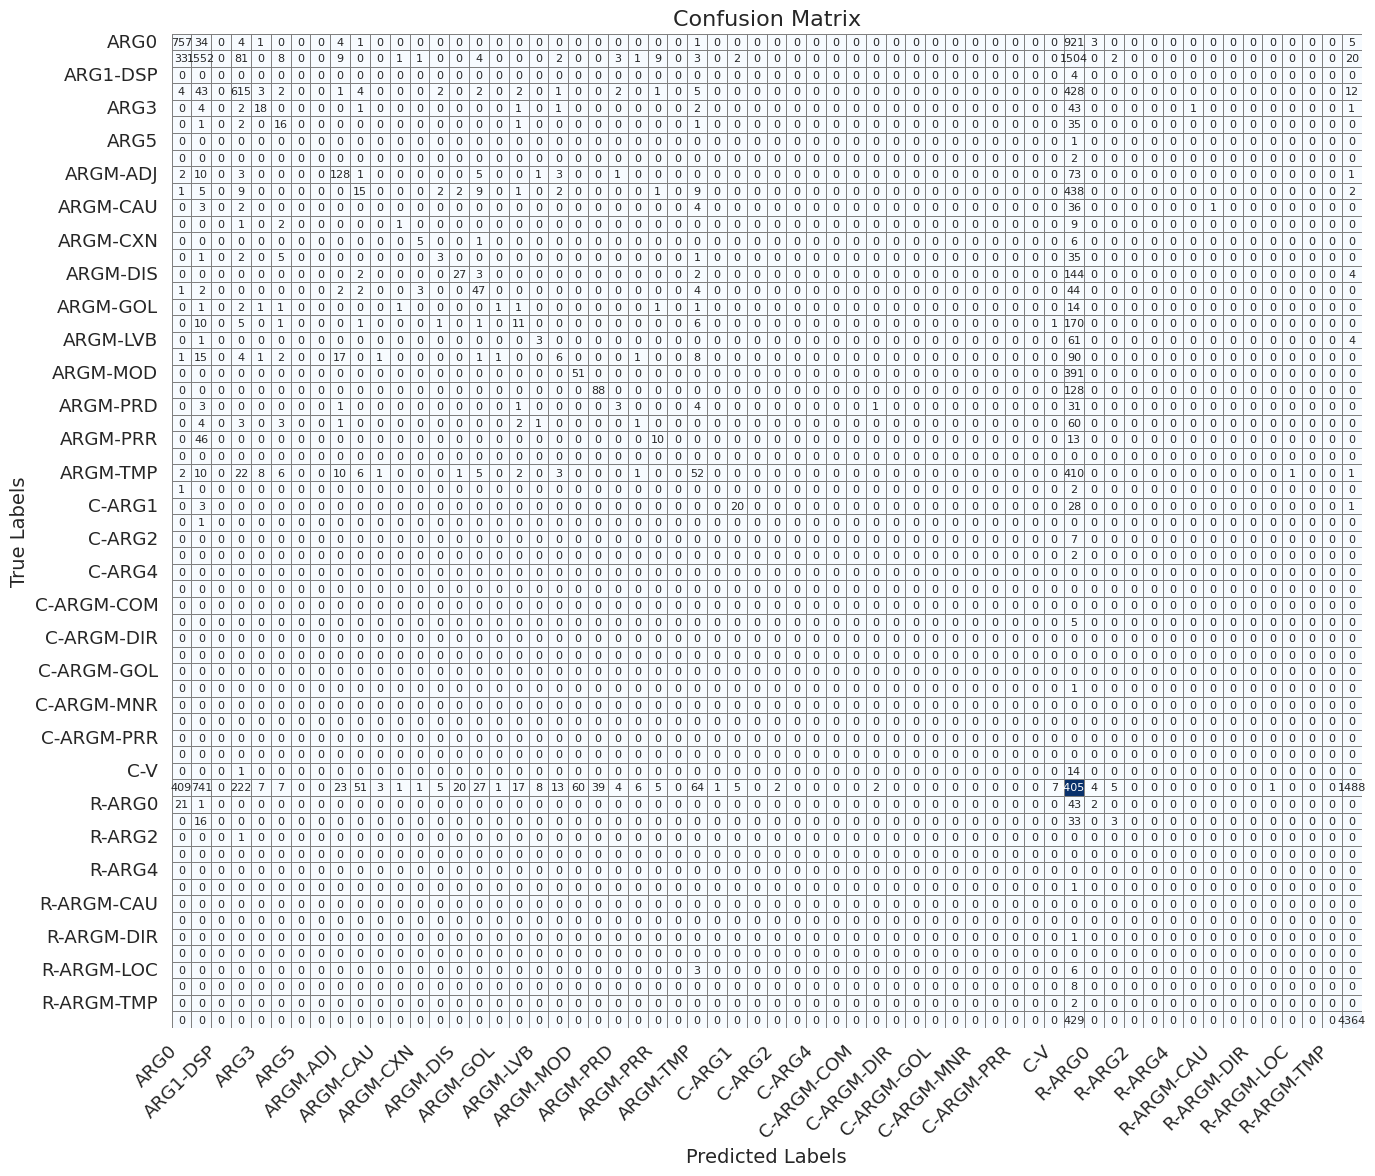

In [24]:
# Evaluate the model and save the results
evaluate_model(model, X_test, y_test, label_encoder, scaler, report_file="new_classification_report.txt", cm_file="new_confusion_matrix.tsv")

### Evaluation

#### Overall Performance:

The model achieves an overall accuracy of 0.90, however, it is misleading as most of the tokens have the 87000 out of the 101000 odd tokens have the label `O` which means they have an empty argument label. The macro average F1-score is 0.18 and the weighted average F1-score is 0.89, which shows that the model performs very well on the majority classes(e.g. `O`, `ARG0`, `ARG1`), but isn't particularly good when predicting rare classes(e.g. `ARG5`, `ARGA`, `R-ARG0`).

#### Performance by Class:

##### High-performing Classes: 

The model performs exceptionally well on the `O` class, with precision = 0.94, recall = 0.96, and F1-score = 0.95. This is expected since `O` is the most frequent class in the dataset. 

The core argument classes `ARG2` and `ARG1` also show strong performance, with F1-scores of 0.58 and 0.54, respectively. This suggests that the model is effective at identifying secondary objects (`ARG2`) and direct objects (`ARG1`).

`ARG0`: The model achieves an F1-score of 0.51 for `ARG0`, indicating reasonable performance for subjects.

`ARGM-ADJ` and `ARGM-NEG`: These modifier classes achieve F1-scores of 0.60 and 0.51, respectively. While not as strong as the core arguments, the model still performs reasonably well on these classes.

##### Low-performing Classes:

Some modifier classes (e.g., `ARGM-CAU`, `ARGM-COM`, `ARGM-DIR`) also perform poorly, with F1-scores below 0.20. This suggests that the model struggles to identify less common or more complex semantic roles.

Many rare classes (e.g., `ARG5`, `ARGA`, `R-ARG2`) have F1-scores of 0.00, indicating that the model fails to predict these classes correctly. This is likely due to the limited number of training examples for these classes.

#### Confusion Matrix Analysis:

The confusion matrix shows that rare classes (e.g., `ARG5`, `ARGA`, `R-ARG2`) are often misclassified as more frequent classes (e.g., `O`, `ARG2`, `ARG1`). This is expected due to the class imbalance in the dataset. There is some confusion between core argument classes (e.g., `ARG0`, `ARG1`, `ARG2`), but the model generally performs well on these classes. Modifier classes (e.g., `ARGM-ADV`, `ARGM-LOC`, `ARGM-TMP`) are often confused with each other or with the O class. This indicates that the model has difficulty distinguishing between different types of modifiers.

### 9. Inference Function

I created a function, that takes as input, a `list` of strings of the tokens in the sentence and an `int` containing the 1-based index of the predicate in the list of strings. Along with that, the model, vectorizer, label_encoder and scaler which is required to make predicted labels for the input sentence. The output of the function is a list of the predicted labels for each of the tokens passed as input. 

In [25]:
def perform_srl(sentence, predicate_id, model, vectorizer, label_encoder, scaler):
    """
    Performs SRL on a standalone sentence given the predicate.

    Args:
        sentence (list): List of words in the sentence.
        predicate_id (int): 1-based index of the predicate in the sentence.
        model (LogisticRegression): Trained logistic regression model.
        vectorizer (DictVectorizer): Fitted vectorizer.
        label_encoder (LabelEncoder): Fitted label encoder.
        scaler (StandardScaler): Fitted scaler.

    Returns:
        list: Predicted semantic roles for each token in the sentence.
    """
    # Extract features for the sentence
    features = extract_features(sentence, predicate_id)

    # Transform features into a sparse matrix
    X = vectorizer.transform(features)

    # Scale the features
    X_scaled = scaler.transform(X)

    # Make predictions
    y_pred = model.predict(X_scaled)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    return y_pred_labels


Some examples usages of the inference function:

In [35]:
sentence = ['Does', 'anybody', 'use', 'it', 'for', 'anything', 'else', '?'] 
predicate_id = 1
predicted_roles = perform_srl(sentence, predicate_id, model, vectorizer, label_encoder, scaler)
print("Predicted Roles:", predicted_roles)

Predicted Roles: ['V' 'O' 'V' 'O' 'O' 'O' 'O' 'O']


In [28]:
sentence = ['Does', 'anybody', 'use', 'it', 'for', 'anything', 'else', '?'] 
predicate_id = 3
predicted_roles = perform_srl(sentence, predicate_id, model, vectorizer, label_encoder, scaler)
print("Predicted Roles:", predicted_roles)

Predicted Roles: ['O' 'O' 'V' 'ARG1' 'O' 'ARG2' 'O' 'O']
